Monte Carlo Simulation is a computation technique that uses random sampling to estimate mathematical functions and mimic the behaviour of various financial instruments. 

In our case, Monte Carlo Simulation is used to model the movement of the stock price under a variety of possible future scenarios, and then determine the option price based off these simulations. Here is a step-by-step breakdown of how Monte Carlo simulation can be used in the context of option pricing:
1) Simulate Stock Price Paths
2) Calculate Payoff for each path
3) Discount the payoff to current value
4) Average the discounted payoffs

We will be going through more on how to execute each steps later on. For now, let us go through the components needed to build a Monte Carlo Option Pricing model.

## Model Parameters

Every model we build requires some parameters, for our case, the Monte Carlo Option Pricing Model would require the following parameters:
1) S0: Intial Stock Price
2) K: Strike Price
3) T: Time to maturity (in years)
4) r: Risk-free interest rate (annual)
5) Sigma: Volatility of stock (annual)

S0 (Inital stock Price): Refers to the price of the stock at the beginning of the simulation. This is the starting point for all simulated stock price paths.

K (Strike price): The price at which the option can be exercised. For a call option, this is the price at which the holder can buy the stock; for a put option, this is the price at which the holder can sell the stock.

T (Time to Maturity): The time remaining until the option expires, expressed in years. This affects the duration over which stock price paths are simulated.

r (Risk-Free Interest Rate): The theorectical rate of return of an investment with zero risk, usually represented by government bonds. It is used to discount the future payoff back to present value.

sigma (Volatility): A measure the stock's fluctuation over time, expressed as an annualised standard deviation. Higher volaitiliy means larger potential price swings.

## Step 1: Simulate stock price paths

To simulate stock price paths, we will need to generate a large number of possible paths for the stock price using the Geometric Brownian model. This involves creating random samples of stock price movements over time and accounting for the expected return (drift) and volatility (random fluctations).

The continuous-time Geometric Brownian Motion is given by the following stochastic differential equation

$$
  dS_t = \mu * S_t + \sigma * S_t dW_t
$$
Where: 

$S_t$ is the stock price at time $t$.

$\mu$ is the drift coefficient, representing the expected rate of return of the stock.

$\sigma$ is the volatility coefficient, representing the standard deviation of stock's returns (a measure of uncertainty or risk).

$W_t$ is a Wiener process or standard Brownian motion, which introduces the random component of the model. 


#### Discretized Form
For practical purposes, especially in simulations, the GBM model is often expressed in its discreteized form:

$$
S_{t+\Delta t} = S_t \exp\left((\mu - \frac{1}{2} \sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z_t \right)
$$

Where:

$\Delta t$ is the discrete time step

$Z$ is a random variable drawn from a standard normal distrbution ($Z$~$N$(0,1)).

### Geometric Brownian Motion - Assumptions

1) Log-Normal Distribution: Geometric Brownian Motion assumes that the logarithm of stock price follows a normal distribution. This ensures that the stock price itself is always positive, which is realistic for real-world financial assets.

2) Continuous path: The model assumes that stock prices change continuously over time, rather than jumping adruptly. This continuous path is more aligned with how prices move in liquid financial markets (i.e. not many sharp increment in prices).

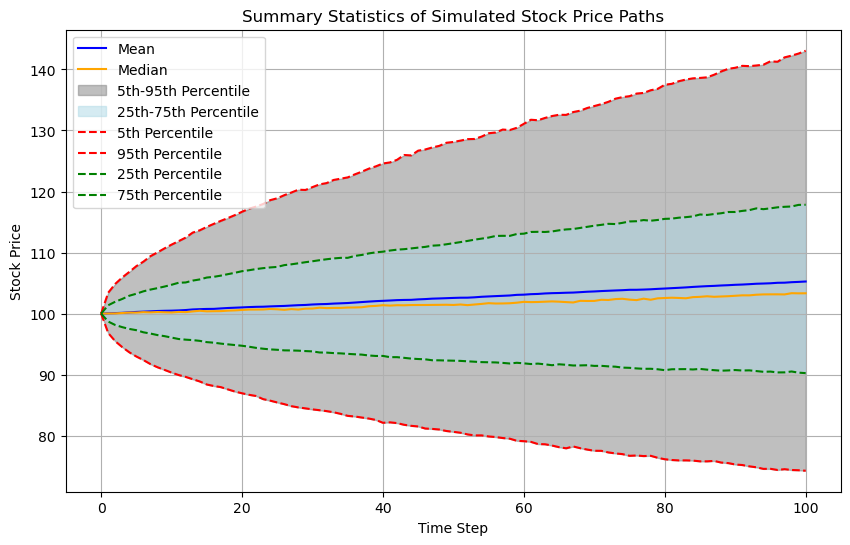

17.23900659044723

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
S0 = 100      # Initial stock price
K = 120       # Strike price
T = 1.0       # Time to maturity in years
r = 0.05      # Risk-free interest rate
sigma = 0.2   # Volatility

option = "put"
n_simulations = 10000
num_steps = 100
dt = T/num_steps

s = np.zeros((num_steps+1, n_simulations)) # each col is a simulation, each row represent a discrete time step 
s[0] = S0
for t in range(1, num_steps+1):
    Z = np.random.standard_normal(n_simulations)
    s[t] = s[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

payoff = 0
if option == "call":
    payoff = np.maximum(s[-1], 0)
elif option == "put":
    payoff = np.maximum(K - s[-1], 0)

# Discount the payoff 
discounted_payoff = payoff * np.exp(-r * T)

option_price = np.mean(discounted_payoff)

mean_price = np.mean(s, axis=1)
median_price = np.median(s, axis=1)
std_price = np.std(s, axis=1)
percentile_5 = np.percentile(s, 5, axis=1)
percentile_25 = np.percentile(s, 25, axis=1)
percentile_75 = np.percentile(s, 75, axis=1)
percentile_95 = np.percentile(s, 95, axis=1)

plt.figure(figsize=(10,6))
time_steps = range(num_steps + 1)
subset_size = 100
plt.plot(time_steps, mean_price, label='Mean', color='blue')
plt.plot(time_steps, median_price, label='Median', color='orange')
plt.fill_between(time_steps, percentile_5, percentile_95, color='gray', alpha=0.5, label='5th-95th Percentile')
plt.fill_between(time_steps, percentile_25, percentile_75, color='lightblue', alpha=0.5, label='25th-75th Percentile')
plt.plot(time_steps, percentile_5, label='5th Percentile', color='red', linestyle='dashed')
plt.plot(time_steps, percentile_95, label='95th Percentile', color='red', linestyle='dashed')
plt.plot(time_steps, percentile_25, label='25th Percentile', color='green', linestyle='dashed')
plt.plot(time_steps, percentile_75, label='75th Percentile', color='green', linestyle='dashed')

plt.title('Summary Statistics of Simulated Stock Price Paths')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
option_price

## Key observations:
<b>Expected Trend:</b>
Both the mean (blue line) and median (orange line) show a slight upward trend over time. This is expected due to the positive risk-free interest rate (r = 0.05), which typically causes the stock prices to grow on average.


<b>Uncertainty and Variability:</b>
The spread between the 5th and 95th percentiles (gray shaded area) widens as time progresses. This indicates increasing uncertainty and variability in the stock prices as time moves closer to maturity. The wider the spread, the higher the uncertainty.

In Monte Carlo simulation, the accuracy of the estimate is often limited by variance of sample mean. Reducing this variance can lead to more accurate and reliable estimates of the expected value. Let us see how we can improve on this model.

### Improving the model - Antithetic Variates
Antithetic Variates helps to reduce variance by generating pairs of dependent random variables that are negatively correlated. By doing so, any high value in one simulation is likely to be offset by a low value in the paired simulation, leading to a more balanced and stable average.

In our case, for a given random variable $Z$ from a standard normal distribution, its antithetic counterpart is -$Z$. The pair ($Z$, $-Z$) ensures that if $Z$ is high, -$Z$ is low, vice versa.

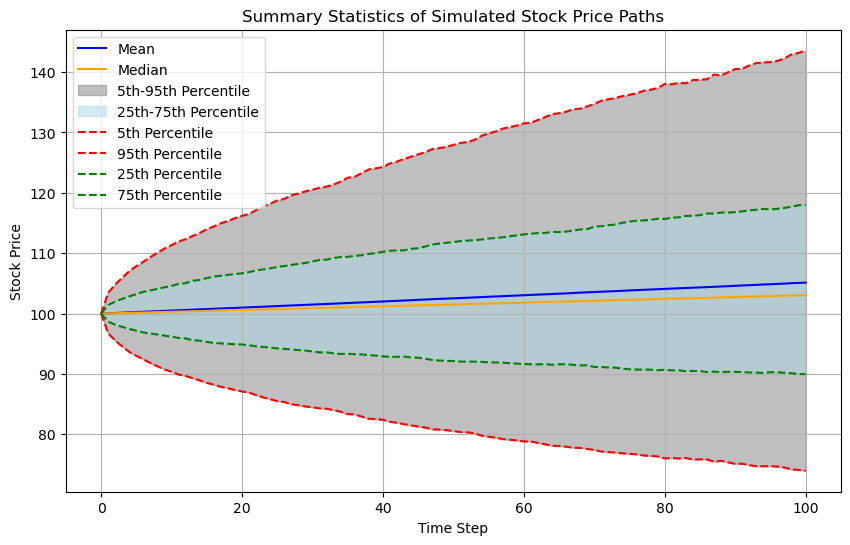

17.398215789760673

In [3]:
import numpy as np
S0 = 100      # Initial stock price
K = 120       # Strike price
T = 1.0       # Time to maturity in years
r = 0.05      # Risk-free interest rate
sigma = 0.2   # Volatility

option = "put"
n_simulations = 10000
num_steps = 100
dt = T/num_steps

s = np.zeros((num_steps+1, n_simulations)) # each col is a simulation, each row represent a discrete time step 
s[0] = S0

Z = np.random.standard_normal((num_steps, n_simulations//2))
Z = np.concatenate((Z, -Z), axis=1)
for t in range(1, num_steps+1):
    s[t] = s[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1])

payoff = 0
if option == "call":
    payoff = np.maximum(s[-1], 0)
elif option == "put":
    payoff = np.maximum(K - s[-1], 0)

# Discount the payoff 
discounted_payoff = payoff * np.exp(-r * T)

mean_price = np.mean(s, axis=1)
median_price = np.median(s, axis=1)
std_price = np.std(s, axis=1)
percentile_5 = np.percentile(s, 5, axis=1)
percentile_25 = np.percentile(s, 25, axis=1)
percentile_75 = np.percentile(s, 75, axis=1)
percentile_95 = np.percentile(s, 95, axis=1)

plt.figure(figsize=(10,6))
time_steps = range(num_steps + 1)
subset_size = 100
plt.plot(time_steps, mean_price, label='Mean', color='blue')
plt.plot(time_steps, median_price, label='Median', color='orange')
plt.fill_between(time_steps, percentile_5, percentile_95, color='gray', alpha=0.5, label='5th-95th Percentile')
plt.fill_between(time_steps, percentile_25, percentile_75, color='lightblue', alpha=0.5, label='25th-75th Percentile')
plt.plot(time_steps, percentile_5, label='5th Percentile', color='red', linestyle='dashed')
plt.plot(time_steps, percentile_95, label='95th Percentile', color='red', linestyle='dashed')
plt.plot(time_steps, percentile_25, label='25th Percentile', color='green', linestyle='dashed')
plt.plot(time_steps, percentile_75, label='75th Percentile', color='green', linestyle='dashed')

plt.title('Summary Statistics of Simulated Stock Price Paths')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

option_price = np.mean(discounted_payoff)
option_price

## Key observations:
Similar key observations can be made for this simulation.

<b>Expected Trend:</b>
Both the mean (blue line) and median (orange line) show a slight upward trend over time. This is expected due to the positive risk-free interest rate (r = 0.05), which typically causes the stock prices to grow on average.


<b>Uncertainty and Variability:</b>
The spread between the 5th and 95th percentiles (gray shaded area) widens as time progresses. This indicates increasing uncertainty and variability in the stock prices as time moves closer to maturity. The wider the spread, the higher the uncertainty.